# Geoanálisis y establecimiento Modelo de Regresión Espacial

#### Importación de las librerías necesarias, algunas de ellas para análisis geoespacial

In [1]:
import pandas as pd
import numpy as np
import csv

#import shapefile as shp #Libreria específica para generación shape.

#Dependencies: conda install -c conda-forge fiona shapely pyproj rtree
import geopandas as gpd # geopandas.org for more information.
from shapely.geometry import Point

#Librerias de machine learnign
from sklearn import cluster
from sklearn.preprocessing import scale

#Data visualization
import seaborn as sns
sns.set(style="whitegrid")

## Lectura ficheros, transformación y generación del Dataframe para el Modelo

Se lee el CSV procedente del script de generación del model final, el cual está agrupado por Contaminante e Id único (defunción).

In [2]:
df_model = pd.read_csv('../data/csv/model_spatial_csv/df_model.csv', sep=';', encoding= 'utf-8',  compression='gzip', index_col=False)

In [3]:
df_model.shape

(938391, 27)

In [4]:
pd.options.display.max_columns = None

In [5]:
df_model['Id'].nunique()

93662

Vemos todas las variables y su tipo

In [6]:
df_model.dtypes

Unnamed: 0               int64
Id                       int64
ProvinciaReside          int64
MunicipioReside          int64
Sexo                     int64
AnioCumplidos            int64
TamanioMuniResi          int64
CausaMortaReduc          int64
NivelEstudios            int64
Poblacion               object
Provincia               object
Comunidad               object
Latitud                float64
Longitud               float64
Habitantes               int64
Hombres                  int64
Mujeres                  int64
CodigoPRTR               int64
LongitudE              float64
LatitudE               float64
Contaminante            object
total_anios_Expo_Id      int64
Total_Kg_expo          float64
COD_3                   object
Descripcion_Cod_3       object
cod_3_num                int64
Contaminante_num         int64
dtype: object

In [7]:
df_model.drop(['Unnamed: 0'], axis=1, inplace=True) #Borramos columnas innecesarias

Comprobamos si alguna columna tiene valores NA para depurarlos

In [8]:
df_model.isnull().any()

Id                     False
ProvinciaReside        False
MunicipioReside        False
Sexo                   False
AnioCumplidos          False
TamanioMuniResi        False
CausaMortaReduc        False
NivelEstudios          False
Poblacion              False
Provincia              False
Comunidad              False
Latitud                False
Longitud               False
Habitantes             False
Hombres                False
Mujeres                False
CodigoPRTR             False
LongitudE              False
LatitudE               False
Contaminante           False
total_anios_Expo_Id    False
Total_Kg_expo          False
COD_3                  False
Descripcion_Cod_3      False
cod_3_num              False
Contaminante_num       False
dtype: bool

## Generación de la Geometría

Se combinan las columnas Longitud y Latitud para crear con Shapely un objeto Geometry de tipo "POINT", 
esto se hará para las localizaciones de los fallecimiento y los puntos de Emisión de contaminantes.

In [9]:
df_model['geometry_death'] = df_model.apply(lambda x: Point((float(x.Longitud), float(x.Latitud))), axis=1)
df_model['geometry_focalEmission'] = df_model.apply(lambda x: Point((float(x.LongitudE), float(x.LatitudE))), axis=1)

Vemos todos los campos y en especial las geometrías creadas tipo POINT

In [10]:
df_model.head(1000)

,Id,ProvinciaReside,MunicipioReside,Sexo,AnioCumplidos,TamanioMuniResi,CausaMortaReduc,NivelEstudios,Poblacion,Provincia,Comunidad,Latitud,Longitud,Habitantes,Hombres,Mujeres,CodigoPRTR,LongitudE,LatitudE,Contaminante,total_anios_Expo_Id,Total_Kg_expo,COD_3,Descripcion_Cod_3,cod_3_num,Contaminante_num,geometry_death,geometry_focalEmission
0,597382,33,44,1,64,6,9,4,Oviedo,Asturias,Asturias,43.36026,-5.844759,224005,104605,119400,4168,-5.811063,43.416965,"1,1,1-tricloroetano (TCE)",2,337.0,C06,TUMOR MALIGNO DE OTRAS PARTES Y DE LAS NO ESPE...,7,0,POINT (-5.844759 43.36026),POINT (-5.8110627 43.4169646)
1,597392,33,44,1,72,6,28,3,Oviedo,Asturias,Asturias,43.36026,-5.844759,224005,104605,119400,4168,-5.811063,43.416965,"1,1,1-tricloroetano (TCE)",2,337.0,C61,TUMOR MALIGNO DE LA PROSTATA,51,0,POINT (-5.844759 43.36026),POINT (-5.8110627 43.4169646)
2,597403,33,44,1,82,6,18,6,Oviedo,Asturias,Asturias,43.36026,-5.844759,224005,104605,119400,4168,-5.811063,43.416965,"1,1,1-tricloroetano (TCE)",2,337.0,C34,TUMOR MALIGNO DE LOS BRONQUIOS Y DEL PULMON,32,0,POINT (-5.844759 43.36026),POINT (-5.8110627 43.4169646)
3,597428,33,44,1,67,6,18,3,Oviedo,Asturias,Asturias,43.36026,-5.844759,224005,104605,119400,4168,-5.811063,43.416965,"1,1,1-tricloroetano (TCE)",2,337.0,C34,TUMOR MALIGNO DE LOS BRONQUIOS Y DEL PULMON,32,0,POINT (-5.844759 43.36026),POINT (-5.8110627 43.4169646)
4,597429,33,44,6,69,6,23,4,Oviedo,Asturias,Asturias,43.36026,-5.844759,224005,104605,119400,4168,-5.811063,43.416965,"1,1,1-tricloroetano (TCE)",2,337.0,C50,TUMOR MALIGNO DE LA MAMA,42,0,POINT (-5.844759 43.36026),POINT (-5.8110627 43.4169646)
5,597445,33,44,1,87,6,67,3,Oviedo,Asturias,Asturias,43.36026,-5.844759,224005,104605,119400,4168,-5.811063,43.416965,"1,1,1-tricloroetano (TCE)",2,337.0,J98,OTROS TRASTORNOS RESPIRATORIOS,119,0,POINT (-5.844759 43.36026),POINT (-5.8110627 43.4169646)
6,597448,33,44,1,57,6,18,5,Oviedo,Asturias,Asturias,43.36026,-5.844759,224005,104605,119400,4168,-5.811063,43.416965,"1,1,1-tricloroetano (TCE)",2,337.0,C34,TUMOR MALIGNO DE LOS BRONQUIOS Y DEL PULMON,32,0,POINT (-5.844759 43.36026),POINT (-5.8110627 43.4169646)
7,597451,33,44,6,52,6,33,10,Oviedo,Asturias,Asturias,43.36026,-5.844759,224005,104605,119400,4168,-5.811063,43.416965,"1,1,1-tricloroetano (TCE)",2,337.0,C71,TUMOR MALIGNO DEL ENCEFALO,61,0,POINT (-5.844759 43.36026),POINT (-5.8110627 43.4169646)
8,597468,33,44,1,86,6,12,2,Oviedo,Asturias,Asturias,43.36026,-5.844759,224005,104605,119400,4168,-5.811063,43.416965,"1,1,1-tricloroetano (TCE)",2,337.0,C18,TUMOR MALIGNO DEL COLON,19,0,POINT (-5.844759 43.36026),POINT (-5.8110627 43.4169646)
9,597491,33,44,1,89,6,28,4,Oviedo,Asturias,Asturias,43.36026,-5.844759,224005,104605,119400,4168,-5.811063,43.416965,"1,1,1-tricloroetano (TCE)",2,337.0,C61,TUMOR MALIGNO DE LA PROSTATA,51,0,POINT (-5.844759 43.36026),POINT (-5.8110627 43.4169646)


Utilizamos geopandas para generar el dataframe geoespacial

In [11]:
geodf1 = gpd.GeoDataFrame(df_model, geometry='geometry_death')
geodf2 = gpd.GeoDataFrame(df_model, geometry='geometry_focalEmission')

Definimos el CRS por defecto según las coordenadas que geocodificamos del google en la etapa primera de geocodificación.
Establecemos el 4326 según EPSG (WGS84)

In [12]:
geodf1.crs = {'init' :'epsg:4326'}
geodf2.crs = {'init' :'epsg:4326'}

Re-proyectamos las coordenadas a EPSG::32630 (WGS84 UTM30N) para luego poder realizar cálculos

In [13]:
geodf1= geodf1.to_crs({'init': 'epsg:32630'})
geodf2= geodf2.to_crs({'init': 'epsg:32630'})

Vemos el nombre de la capa activa 'geometry' para el geoDataframe segundo

In [14]:
geodf2.geometry.name

'geometry_focalEmission'

Podemos ver los límites mínimos y máximos para la Longitud (X) y Latitud (Y)

In [15]:
geodf1.geometry.total_bounds

array([-851359.48631016, 3149755.02191041, 1121363.98328194,
       4833510.85541308])

In [16]:
len(geodf1)

938391

Se genera antes la columna Distance en el geodataframe primero, en la cual se almacenará la distancia entre los dos puntos

In [17]:
geodf1.loc[:,'Distance']=''

Se itera sobre la Geometría de uno de los Dataframes y se obtiene mediante el método "distance" las distancias entre puntos

In [18]:
for x,point in enumerate(geodf1.geometry):
    geodf1.Distance.at[x] = geodf1.geometry.iloc[x].distance(geodf2.geometry.iloc[x])

In [19]:
geodf1['Distance'].unique()

array([6867.759740210821, 2276.7177474637288, 6112.005222737624, ...,
       4448.817951093396, 8146.6125055958, 6337.897463023235],
      dtype=object)

Redondeamos los decimales de la distancia, no queremos tanto detalle

In [20]:
geodf1['Distance'] = geodf1['Distance'].apply(lambda x: int(x))

In [21]:
geodf1.sample(10000).sort_values(by='Distance', ascending=True)

,Id,ProvinciaReside,MunicipioReside,Sexo,AnioCumplidos,TamanioMuniResi,CausaMortaReduc,NivelEstudios,Poblacion,Provincia,Comunidad,Latitud,Longitud,Habitantes,Hombres,Mujeres,CodigoPRTR,LongitudE,LatitudE,Contaminante,total_anios_Expo_Id,Total_Kg_expo,COD_3,Descripcion_Cod_3,cod_3_num,Contaminante_num,geometry_death,geometry_focalEmission,Distance
98187,128560,17,114,6,91,3,35,2,Olot,Girona,Catalunya,42.18211,2.488189,33524,16856,16668,5700,2.488024,42.182208,Compuestos orgánicos volátiles distintos del m...,1,8.380000e+05,C80,TUMOR MALIGNO DE SITIOS NO ESPECIFICADOS,67,14,POINT (953289.0885149569 4684597.355148673),POINT (2.4880242 42.1822078),17
98199,128786,17,114,6,89,3,36,3,Olot,Girona,Catalunya,42.18211,2.488189,33524,16856,16668,5700,2.488024,42.182208,Compuestos orgánicos volátiles distintos del m...,1,8.380000e+05,C90,MIELOMA MULTIPLES Y TUMORES MALIGNOS DE CELULA...,68,14,POINT (953289.0885149569 4684597.355148673),POINT (2.4880242 42.1822078),17
403477,61074,12,84,1,64,3,18,4,Onda,Castellón/Castelló,Valencia,39.96530,-0.262645,25691,13149,12542,662,-0.262595,39.965130,Óxidos de azufre (SOx/SO2),1,2.800000e+05,C34,TUMOR MALIGNO DE LOS BRONQUIOS Y DEL PULMON,32,28,POINT (733793.7192276958 4427494.644059891),POINT (-0.2625949 39.96513),19
403511,61510,12,84,6,50,3,23,4,Onda,Castellón/Castelló,Valencia,39.96530,-0.262645,25691,13149,12542,662,-0.262595,39.965130,Óxidos de azufre (SOx/SO2),1,2.800000e+05,C50,TUMOR MALIGNO DE LA MAMA,42,28,POINT (733793.7192276958 4427494.644059891),POINT (-0.2625949 39.96513),19
285310,141840,17,95,6,73,3,26,4,Lloret de Mar,Girona,Catalunya,41.69878,2.847584,39363,20879,18484,850,2.847688,41.698543,Metano (CH4),1,1.995233e+06,C56,TUMOR MALIGNO DEL OVARIO,48,22,POINT (986657.8835151552 4632883.561998289),POINT (2.8476882 41.6985435),27
159307,68802,13,71,1,83,4,28,1,Puertollano,Ciudad Real,Castilla La Mancha,38.68604,-4.112146,51842,25334,26508,5649,-4.112350,38.685830,Dióxido de carbono (CO2),2,3.510000e+08,C61,TUMOR MALIGNO DE LA PROSTATA,51,17,POINT (403271.844955073 4282523.869460717),POINT (-4.11235 38.68583),29
159348,69334,13,71,1,57,4,18,3,Puertollano,Ciudad Real,Castilla La Mancha,38.68604,-4.112146,51842,25334,26508,5649,-4.112350,38.685830,Dióxido de carbono (CO2),2,3.510000e+08,C34,TUMOR MALIGNO DE LOS BRONQUIOS Y DEL PULMON,32,17,POINT (403271.844955073 4282523.869460717),POINT (-4.11235 38.68583),29
468849,69285,13,71,1,65,4,12,4,Puertollano,Ciudad Real,Castilla La Mancha,38.68604,-4.112146,51842,25334,26508,5649,-4.112350,38.685830,Óxidos de nitrógeno (NOx/NO2),1,1.036650e+05,C18,TUMOR MALIGNO DEL COLON,19,29,POINT (403271.844955073 4282523.869460717),POINT (-4.11235 38.68583),29
125956,982412,7,40,6,74,6,22,5,Palma,Illes Balears,Islas Baleares,39.56951,2.649966,401270,197436,203834,132,2.650331,39.569551,Cromo y compuestos (como Cr),1,1.540000e+02,C44,OTROS TUMORES MALIGNO DE LA PIEL,38,15,POINT (985443.4064153091 4395252.984604313),POINT (2.6503313 39.56955079999999),31
126751,991398,7,40,1,79,6,18,3,Palma,Illes Balears,Islas Baleares,39.56951,2.649966,401270,197436,203834,132,2.650331,39.569551,Cromo y compuestos (como Cr),1,1.540000e+02,C34,TUMOR MALIGNO DE LOS BRONQUIOS Y DEL PULMON,32,15,POINT (985443.4064153091 4395252.984604313),POINT (2.6503313 39.56955079999999),31


#### Cargamos el shape de municipios descargado de la página de Datos abiertos de ESRI (datos del IGN)

In [22]:
municipios = gpd.read_file('../data/shapes/municipios.ign/Municipios_IGN.shp')

In [23]:
municipios.head()

,OBJECTID,INSPIREID,NATCODE,CODNUT1,CODNUT2,CODNUT3,NAMEUNIT,CODIGOINE,geometry
0,3001,ES.IGN.SIGLIM34073434161,34073434161,ES4,ES41,ES414,San Cristóbal de Boedo,34161,"POLYGON ((-4.37610841038301 42.5484911697205, ..."
1,3002,ES.IGN.SIGLIM34073434163,34073434163,ES4,ES41,ES414,San Mamés de Campos,34163,"POLYGON ((-4.58329842028732 42.3641575497321, ..."
2,3003,ES.IGN.SIGLIM34073434168,34073434168,ES4,ES41,ES414,Santa Cruz de Boedo,34168,"POLYGON ((-4.4222077804343 42.5457855802628, -..."
3,3004,ES.IGN.SIGLIM34073434169,34073434169,ES4,ES41,ES414,Santervás de la Vega,34169,"POLYGON ((-4.89999934973616 42.4506824300329, ..."
4,3005,ES.IGN.SIGLIM34073434171,34073434171,ES4,ES41,ES414,Santibáñez de la Peña,34171,"POLYGON ((-4.80106393041723 42.7464759601427, ..."


Asignamos el CRS de los municipios al dataframe de geopandas, para asegurarnos en la transformación

In [24]:
geodf1 = geodf1.to_crs(municipios.crs)

Creamos primero el plot de municipios como base

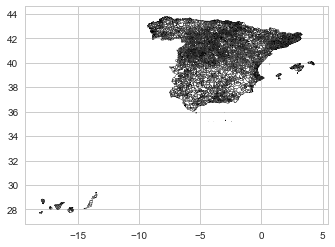

In [25]:
base = municipios.plot(color='white', edgecolor='black')

In [26]:
geodf1.plot(ax=base, marker='o', color='red', markersize=5)

Vamos a utilizar matplolib para plotearlo mejor

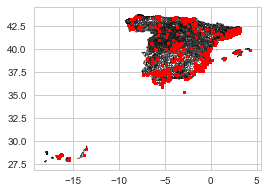

In [27]:
import matplotlib.pyplot as plt

fig, ax = plt.subplots(figsize=(9, 3), sharey=True)

ax.set_aspect('equal')

municipios.plot(ax=ax, color='white', edgecolor='black')
geodf1.plot(ax=ax, marker='o', color='red', markersize=5, legend=True)

plt.show()

In [28]:
geodf1.corr()

,Id,ProvinciaReside,MunicipioReside,Sexo,AnioCumplidos,TamanioMuniResi,CausaMortaReduc,NivelEstudios,Latitud,Longitud,Habitantes,Hombres,Mujeres,CodigoPRTR,LongitudE,LatitudE,total_anios_Expo_Id,Total_Kg_expo,cod_3_num,Contaminante_num,Distance
Id,1.000000,0.034691,0.205410,-0.006262,0.006453,-0.007557,-0.020952,0.002230,0.187567,0.518932,-0.084372,-0.081141,-0.087239,0.038983,0.519302,0.187512,0.032018,0.028765,-0.026581,-0.011465,0.079181
ProvinciaReside,0.034691,1.000000,0.254237,-0.009480,-0.012272,0.029380,-0.033610,-0.005491,-0.014777,-0.364109,-0.076213,-0.077101,-0.075420,0.114793,-0.363305,-0.015069,0.101190,-0.046522,-0.028239,0.006200,0.009146
MunicipioReside,0.205410,0.254237,1.000000,-0.010163,-0.010897,-0.092582,-0.004131,-0.003678,0.092315,0.200741,-0.082582,-0.081730,-0.083335,0.012269,0.200834,0.092215,-0.041023,-0.045053,-0.003763,-0.042120,0.097478
Sexo,-0.006262,-0.009480,-0.010163,1.000000,0.098956,0.038825,0.069856,-0.029266,0.004141,-0.004308,0.037807,0.037817,0.037797,0.000064,-0.004302,0.004039,-0.001482,-0.001371,0.075076,0.004900,-0.017939
AnioCumplidos,0.006453,-0.012272,-0.010897,0.098956,1.000000,0.040263,0.310502,-0.182346,0.056241,0.027667,0.078611,0.078469,0.078734,0.002123,0.027588,0.056150,0.003105,-0.002033,0.311942,0.008302,-0.028609
TamanioMuniResi,-0.007557,0.029380,-0.092582,0.038825,0.040263,1.000000,0.016300,0.029130,-0.074284,-0.046930,0.469981,0.472462,0.467757,-0.007794,-0.046770,-0.075509,0.007789,0.017669,0.017148,0.064234,-0.253958
CausaMortaReduc,-0.020952,-0.033610,-0.004131,0.069856,0.310502,0.016300,1.000000,-0.020927,-0.019144,0.001196,0.055130,0.055054,0.055195,-0.007524,0.001234,-0.019183,-0.012871,-0.002859,0.987276,0.003521,-0.018959
NivelEstudios,0.002230,-0.005491,-0.003678,-0.029266,-0.182346,0.029130,-0.020927,1.000000,-0.004615,0.010715,0.036534,0.036612,0.036463,0.000246,0.010735,-0.004657,-0.004060,-0.001564,-0.022399,0.006518,-0.009870
Latitud,0.187567,-0.014777,0.092315,0.004141,0.056241,-0.074284,-0.019144,-0.004615,1.000000,0.480876,0.017998,0.016962,0.018918,0.069509,0.479987,0.999950,0.126188,-0.002127,-0.020000,0.001250,0.085184
Longitud,0.518932,-0.364109,0.200741,-0.004308,0.027667,-0.046930,0.001196,0.010715,0.480876,1.000000,0.085284,0.088385,0.082524,0.073951,0.999967,0.481413,-0.022873,0.007391,-0.004794,-0.018747,0.052391


Ploteamos las longitudes y latitudes, observamos que hay algún punto fuera de rango

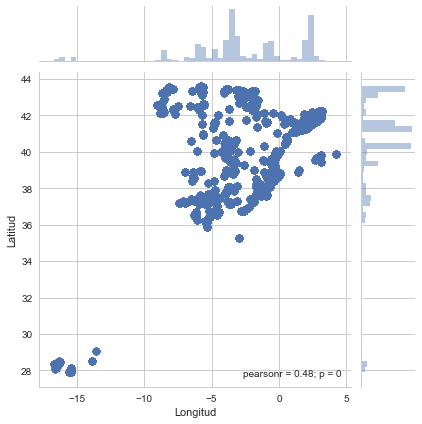

In [29]:
sns.jointplot(x="Longitud", y="Latitud", data=geodf1);

Modificamos valores fuera de rango

In [30]:
len(geodf1)

938391

Salvamos a CSV antes de realizar operaciones y salvar a shape file

In [31]:
geodf1.to_csv('../data/csv/model_spatial_csv/df_model_spatial_Geom_deaths_dist.csv', sep=';', encoding= 'utf-8',  compression='gzip')

Para salvar a shape file necesitamos sólo una geometría por fichero... sólo nos quedamos con las columnas necesarias para el estudio.

In [32]:
#Nos quedamos solo con las columnas que nos interesan para el estudio geospacial.

cols_of_interest_1= ['Id','ProvinciaReside', 'MunicipioReside','Sexo', 'AnioCumplidos', \
       'TamanioMuniResi', 'CausaMortaReduc', 'NivelEstudios',   \
        'Poblacion', 'Provincia', 'Comunidad', 'Latitud', 'Longitud', 'Habitantes', 'Hombres', 'Mujeres', \
        'LongitudE','LatitudE','Contaminante','total_anios_Expo_Id','Total_Kg_expo','COD_3','Descripcion_Cod_3', 'cod_3_num',\
         'geometry_death', 'Distance','Contaminante_num'] 

cols_of_interest_2= ['Id','LongitudE','LatitudE','geometry_focalEmission']   


geodf1 = geodf1[cols_of_interest_1]          
geodf2 = geodf2[cols_of_interest_2]                              

Salvamos a shape el geoDataframe con las distancias, luego lo utilizaremos para la regresion espacial. Nota: Este proceso puede durar varios minutos en función del procesador.

In [33]:
pathname1='../data/shapes/Deaths/Deaths2015.shp'
pathname2= '../data/shapes/FocalEmissions/FocalEmissions2015.shp'

In [34]:
geodf1.to_file(pathname1, driver="ESRI Shapefile")
geodf2.to_file(pathname2, driver="ESRI Shapefile")

## Modelos de Regresión con Pysal

In [35]:
#For Spatial Correlation
# !pip install pysal
#http://pysal.readthedocs.io/en/latest/
import pysal
from pysal.spreg import ols
from pysal.spreg import ml_error
from pysal.spreg import ml_lag

In [36]:
shp_path = '../data/shapes/Deaths/Deaths2015.shp'
dbf_path = '../data/shapes/Deaths/Deaths2015.dbf'

Debido a que el shape es muy pesado para realizar un análisis de regresión espacial vamos a seleccionar una zona concreta y nos quedaremos sólo con fallecimientos producidos en la Comunidad de Madrid por debajo de la distancia de 5000 metros al punto contaminante

In [38]:
df = gpd.read_file(shp_path)

In [39]:
df_filt_Mad = df[ (df['Comunidad'] == 'Madrid') &  (df['Distance'] <= 5000) ]

Realizamos un muestreo aleatorio con numpy de 400 registros

In [40]:
rows = np.random.choice(df_filt_Mad.index.values, 300)

In [41]:
df_filt_Mad_sampled = df_filt_Mad.loc[rows]

In [42]:
df_filt_Mad_sampled.shape

(300, 27)

In [43]:
np.random.seed(12345)
y = np.array(df_filt_Mad_sampled['cod_3_num'])
y.shape = (len(y),1)
X= []
X.append(df_filt_Mad_sampled['Total_Kg_e'])
X.append(df_filt_Mad_sampled['total_anio'])
X.append(df_filt_Mad_sampled['Distance'])

X = np.array(X).T

#### Realizamos una regresión lineal por MCO (Nonspatial regression)

In [44]:
ls = ols.OLS(y, X, name_y = 'Causa Muerte Principal', name_x = ['Total Kg Expo','Total años Expo','Distance'], name_ds = 'Deaths')
print(ls.summary)

REGRESSION
----------
SUMMARY OF OUTPUT: ORDINARY LEAST SQUARES
-----------------------------------------
Data set            :      Deaths
Weights matrix      :        None
Dependent Variable  :Causa Muerte Principal                Number of Observations:         300
Mean dependent var  :     64.0167                Number of Variables   :           4
S.D. dependent var  :     38.3655                Degrees of Freedom    :         296
R-squared           :      0.0126
Adjusted R-squared  :      0.0025
Sum squared residual:  434574.874                F-statistic           :      1.2546
Sigma-square        :    1468.158                Prob(F-statistic)     :      0.2902
S.E. of regression  :      38.317                Log likelihood        :   -1517.433
Sigma-square ML     :    1448.583                Akaike info criterion :    3042.865
S.E of regression ML:     38.0603                Schwarz criterion     :    3057.681

-------------------------------------------------------------------

#### Establecemos las matrices para los pesos espaciales (Spatial Weights) de dos formas distintas:

#### Distance band weights: 

Esta es una opción basada en la distancia, estableciendo bandas de distancia o umbrales para definir el conjunto vecino para cada unidad espacial como aquellas otras unidades que se encuentran dentro de una distancia umbral de la unidad focal

In [45]:
dbb = pysal.weights.DistanceBand.from_dataframe(df_filt_Mad_sampled, threshold=.9, binary=False)
#wknn3 = pysal.weights.KNN(df_filt_Mad_sampled, k = 3)
#dbc = pysal.weights.DistanceBand.from_dataframe(df_filt_Mad_sampled, threshold=.9, binary=True)
#q = pysal.weights.Queen.from_dataframe(df_filt_Mad_sampled)
#r = pysal.weights.Rook.from_dataframe(df_filt_Mad_sampled)
#q2 = pysal.weights.Queen.from_dataframe(df.query('DISCBD < 2'))

In [46]:
dbb.n

300

#### Kernel Weights

Este método es una combinación de umbrales basados en la distancia junto con los pesos del kernel. En nuestro caso el ancho de banda se establece en un valor predeterminado y se fija a través de las observaciones

In [47]:
kw = pysal.weights.Kernel.from_dataframe(df_filt_Mad_sampled)

In [48]:
kw.n

300

Estandarizamos rows

In [49]:
kw.transform = 'r'
dbb.transform = 'r'

Vamos a realizar otro modelo de Regresión Lineal

In [50]:
#lst = df_filt_Mad_sampled
#lst.index = pd.RangeIndex(len(lst.index))
#x = ['cod_3_num', 'Contamin_1', 'Total_Kg_e', 'total_anio', 'Distance']

In [51]:
#yxs = lst.loc[:, x ].dropna()

In [52]:
#w = ps.knnW_from_array(lst.loc[yxs.index, ['Longitud', 'Latitud']].values)
#w.transform = 'R'

## Modelos de regresión espacial

### Global Autocorrelation

#### Para ver la no independencia espacial, primero utilizamos la función I de Moran desde un punto de vista global

Los valores de I pueden oscilar entre -1 (indicando dispersión perfecta) a 1 (correlación perfecta). Un valor de cero indica un patrón espacial aleatorio.

In [53]:
# Pasamos los weights matrix a la función pysal.Moran, a través de nuestro modelo residual (ls.u)
mi = pysal.Moran(ls.u, dbb, two_tailed=False)
print('Observed I:', mi.I, '\nExpected I:', mi.EI, '\n   p-value:', mi.p_norm)

Observed I: -0.004044475758210746 
Expected I: -0.0033444816053511705 
   p-value: 0.43051735693416576


In [54]:
mi = pysal.Moran(ls.u, kw, two_tailed=False)
print('Observed I:', mi.I, '\nExpected I:', mi.EI, '\n   p-value:', mi.p_norm)

Observed I: 0.0041251135697575785 
Expected I: -0.0033444816053511705 
   p-value: 0.11860749822213124


#### Utilizamos otro estadístico la Geary’s C, que es más sensible a la autocorrelación espacial local.

In [55]:
np.random.seed(12345)
gc = pysal.Geary(y, kw)
print('Observed C:' ,gc.C, '\nExpected C:' ,gc.EC, '\nZ-norm:', gc.z_norm, '\n  p-value:', gc.p_norm)

Observed C: 0.9889309722177213 
Expected C: 1.0 
Z-norm: -1.289077104528904 
  p-value: 0.09868564116420869


### Local Autocorrelation: Local Indicators of Spatial Association (LISAs) 

Vamos a utilizar un método de autocorrelación local quizá más real para nuestro estudio, utilizamos la I de Moran

In [56]:
lm = pysal.Moran_Local(y,kw)
lm.n

300

El siguiente método arroja unos pseudo p-values para cada LISA

In [57]:
lm.p_sim

array([0.439, 0.319, 0.142, 0.44 , 0.3  , 0.419, 0.47 , 0.151, 0.469,
       0.495, 0.479, 0.273, 0.497, 0.473, 0.25 , 0.285, 0.282, 0.299,
       0.233, 0.323, 0.244, 0.266, 0.46 , 0.338, 0.453, 0.254, 0.474,
       0.358, 0.259, 0.31 , 0.32 , 0.243, 0.348, 0.273, 0.253, 0.477,
       0.367, 0.301, 0.241, 0.276, 0.305, 0.29 , 0.31 , 0.311, 0.365,
       0.415, 0.276, 0.371, 0.486, 0.262, 0.317, 0.26 , 0.497, 0.431,
       0.097, 0.305, 0.353, 0.485, 0.33 , 0.087, 0.257, 0.392, 0.358,
       0.451, 0.32 , 0.302, 0.475, 0.45 , 0.25 , 0.476, 0.395, 0.322,
       0.31 , 0.289, 0.472, 0.293, 0.315, 0.499, 0.34 , 0.274, 0.47 ,
       0.451, 0.304, 0.454, 0.298, 0.234, 0.286, 0.302, 0.303, 0.488,
       0.463, 0.484, 0.431, 0.498, 0.496, 0.47 , 0.349, 0.244, 0.282,
       0.347, 0.317, 0.327, 0.331, 0.267, 0.47 , 0.344, 0.47 , 0.442,
       0.235, 0.477, 0.489, 0.258, 0.417, 0.37 , 0.335, 0.46 , 0.492,
       0.157, 0.289, 0.163, 0.242, 0.173, 0.467, 0.499, 0.271, 0.25 ,
       0.47 , 0.28 ,

Identificamos los valores LISA por debajo de 0.05 significantes y los indexamos

In [58]:
sig = lm.p_sim < 0.05
print(lm.p_sim[sig])

[]


Utilizamos el atributo q para localizar en que cuadrante del Scatter de Moran estan ubicados

In [59]:
lm.q[sig]

array([], dtype=int32)

Vamos a utilizar las variables Sexo y habitantes del municipio basadas en la población con diferentes tamaños para tener en cuenta las diferencias entre la población y estimar el Is de Moran local

In [60]:
b = np.array(df_filt_Mad_sampled['Sexo'])
e = np.array(df_filt_Mad_sampled['Habitantes'])

np.random.seed(12345)
lm = pysal.esda.moran.Moran_Local_Rate(e, b, kw)
lm.Is[:]

array([ 0.12860884,  0.12860884,  0.03392097,  0.12860884,  0.12860884,
        0.12860884, -0.08771098,  0.03712317, -0.08771098,  0.12860884,
       -0.08771098,  0.12860884,  0.12860884,  0.02382586,  0.12860884,
        0.12860884,  0.12860884,  0.03712317,  0.12860884,  0.12860884,
        0.12860884,  0.12860884, -0.08771098,  0.12860884,  0.02382586,
       -0.08771098, -0.08771098, -0.08771098, -0.08771098,  0.12860884,
        0.12860884,  0.12860884,  0.12860884, -0.08771098,  0.12860884,
       -0.08771098, -0.08771098, -0.08771098,  1.26615126,  0.12860884,
        0.12860884, -0.08771098, -0.08771098, -0.08771098,  0.12860884,
        0.12860884,  0.12860884, -0.08771098, -0.08771098, -0.08771098,
       -0.08771098,  0.12860884,  0.12860884,  1.22363943, -0.03285583,
        0.03392097, -0.08771098, -0.08771098, -0.08771098, -0.03285583,
       -0.08771098,  0.02153381,  0.12860884, -0.08771098, -0.08771098,
        0.12860884, -0.08771098,  1.22363943, -0.08771098,  0.12

In [61]:
sig = lm.p_sim < 0.05
lm.p_sim[sig]

array([0.001, 0.001, 0.021, 0.001, 0.001, 0.001, 0.001, 0.017, 0.001,
       0.001, 0.001, 0.001, 0.001, 0.001, 0.001, 0.001, 0.012, 0.001,
       0.001, 0.001, 0.001, 0.001, 0.001, 0.048, 0.001, 0.001, 0.001,
       0.001, 0.001, 0.001, 0.001, 0.001, 0.001, 0.001, 0.001, 0.001,
       0.001, 0.007, 0.001, 0.001, 0.001, 0.001, 0.001, 0.001, 0.001,
       0.001, 0.001, 0.001, 0.001, 0.001, 0.001, 0.001, 0.001, 0.017,
       0.001, 0.001, 0.001, 0.001, 0.001, 0.001, 0.001, 0.001, 0.001,
       0.001, 0.001, 0.001, 0.001, 0.001, 0.001, 0.001, 0.001, 0.001,
       0.001, 0.001, 0.001, 0.001, 0.001, 0.001, 0.001, 0.001, 0.001,
       0.001, 0.001, 0.001, 0.001, 0.001, 0.001, 0.001, 0.001, 0.001,
       0.001, 0.001, 0.001, 0.001, 0.001, 0.001, 0.001, 0.001, 0.001,
       0.001, 0.001, 0.001, 0.001, 0.001, 0.001, 0.001, 0.001, 0.001,
       0.001, 0.001, 0.001, 0.017, 0.001, 0.009, 0.011, 0.012, 0.001,
       0.001, 0.001, 0.001, 0.001, 0.001, 0.001, 0.012, 0.001, 0.001,
       0.001, 0.001,

Plotting con Seaborn

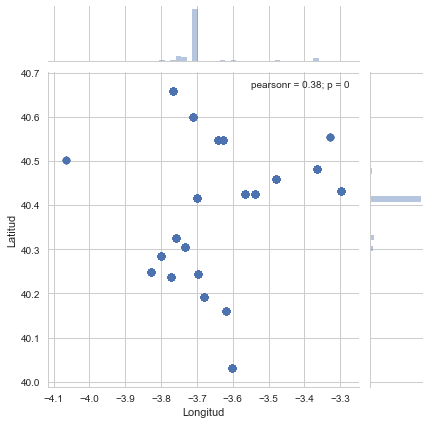

In [62]:
sns.jointplot(x="Longitud", y="Latitud", data=df_filt_Mad);

In [1]:
import folium
from folium.plugins import MarkerCluster
import pandas as pd

Generamos un objeto pysal para manejar las geometrías

In [2]:
#f = pysal.open(shp_path,'r')
#f.header

In [3]:
#Define coordinates of where we want to center our map
madrid_coords = [40.4167, -3.70325]

#Create the map
my_map = folium.Map(location = madrid_coords, zoom_start = 13)

#Display the map
my_map

In [5]:
#Add markers to the map
deaths= pd.read_csv('../data/csv/model_spatial_csv/df_model_spatial_Geom_deaths_dist.csv', sep=';', encoding= 'utf-8',  compression='gzip')

#deaths.head()

In [7]:
points_deaths = deaths[deaths.Provincia == 'Madrid'][['geometry_death', 'Descripcion_Cod_3']]

for index, row in points_deaths.iterrows():
    my_map.add_children(row['geometry_death'])
    my_map.add_to(row['geometry_death'])

C:\Users\julia\Anaconda3\lib\site-packages\ipykernel_launcher.py:4: FutureWarning: Method `add_children` is deprecated. Please use `add_child` instead.
  after removing the cwd from sys.path.


AttributeError: 'str' object has no attribute 'get_name'

In [ ]:
my_map.save("../data/html/mapaDeaths2015.html")

In [85]:

m = folium.Map([43,-100], zoom_start=4)
json = 'spain-provinces.json'
m.choropleth(
    geo_str=open(json).read(),
    data=deaths,
    columns=[ 'Provincias'],
    key_on='feature.id',
    fill_color='YlGn',
    )
m

FileNotFoundError: [Errno 2] No such file or directory: 'spain-provinces.json'